In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [11]:
# Dataset Prep
data_path = r"C:\Users\LENOVO\Desktop\Python\Datasets\Alzeimehers\Data"

datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.2,  
                             horizontal_flip=True,
                             zoom_range=0.2)

train_generator = datagen.flow_from_directory(data_path,
                                              target_size=(224, 224),
                                              batch_size=128,
                                              class_mode='binary',
                                              subset='training')

val_generator = datagen.flow_from_directory(data_path,
                                            target_size=(224, 224),
                                            batch_size=128,
                                            class_mode='binary',
                                            subset='validation')


Found 14982 images belonging to 2 classes.
Found 3745 images belonging to 2 classes.


In [12]:
print(train_generator.class_indices)

{'Mild_Dementia': 0, 'Very_mild_Dementia': 1}


In [13]:
class_indices = train_generator.class_indices 
classes = list(class_indices.values())

labels = train_generator.classes  

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(zip(classes, class_weights))

print(class_weight_dict)


{0: np.float64(1.8718140929535232), 1: np.float64(0.6822404371584699)}


In [3]:
# Load base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)  

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step


In [7]:
# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

In [ ]:
# Train
history = model.fit(train_generator,
          validation_data=val_generator,
          epochs=10,)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.title('Loss per Epoch');

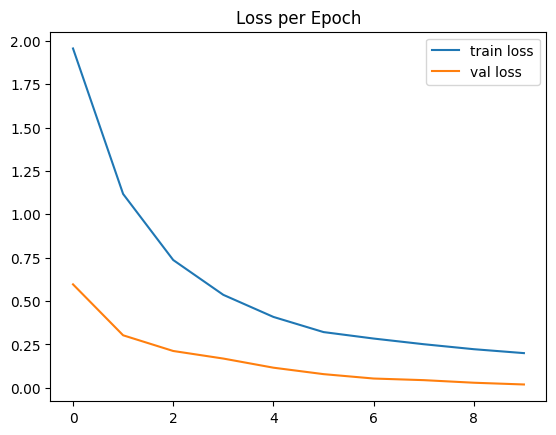

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy');

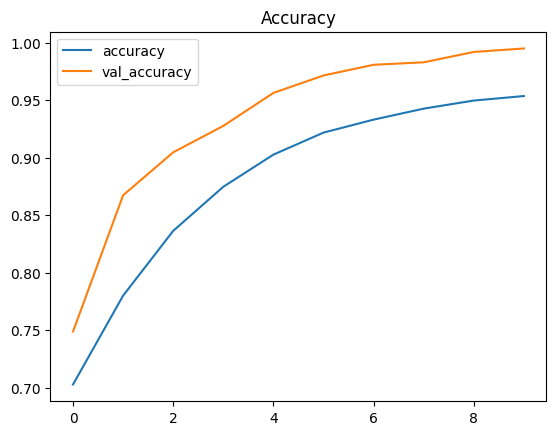

# **Model Architecture Overview**

### **1. Base Model**
- **Architecture**: VGG16

- **Weights**: Pretrained on ImageNet

- **Include Top**: False (excludes the fully connected layers of the original model)

- **Trainable Layers**: All layers in the base model are frozen to retain learned features.

### **2. Custom Classification Head**
The following layers are appended on top of the base model to adapt it for binary classification:

- **Flatten Layer**

- **Dense Layer**

  - Units: 256

  - Activation: `ReLU`

- **Dropout Layer**

  - Rate: 0.5

- **Output Layer (Dense)**

  - Units: 1

  - Activation: `Sigmoid`


### **2. Compilation** 
- **Loss Function**: `BinaryCrossentropy`

- **Optimizer**: `Adam(1e-4)`

- **Evaluation Metric**: `Accuracy`, `Precision`, `Recall`

# **Code Overview**

### **1. Dataset Preparation**
The dataset consists of medical images organized into subdirectories based on their class labels. Using ImageDataGenerator, the dataset is preprocessed with the following steps:

Normalization: All pixel values are rescaled to the range [0, 1].

Data Augmentation: Techniques like horizontal flipping and zooming are applied to the training set to improve the model’s generalization.

Splitting: The dataset is divided into training (80%) and validation (20%) subsets automatically.

### **2. Handling Class Imbalance**
To address the imbalance between classes (e.g., 1300 vs. 5000 samples), class weights are computed. These weights adjust the model's learning process to give more importance to the underrepresented class, helping the model avoid bias toward the majority class.

### **3. Model Architecture**
- **Base Model (VGG16)**
The model uses the VGG16 architecture pretrained on the ImageNet dataset. The top classification layers of VGG16 are removed, and its convolutional layers are frozen to retain their feature extraction capabilities without updating them during training.

- **Custom Classification Head**
  - A new classifier is added on top of the frozen VGG16 base:

  - A flattening layer converts the feature maps into a 1D vector.

  - A dense layer with ReLU activation captures complex patterns.

  - A dropout layer with 50% rate helps prevent overfitting.

  - A final dense layer with sigmoid activation outputs a binary probability score for classification.

### **4. Compilation**
The model is compiled using the Adam optimizer with a low learning rate to fine-tune the new layers gradually. The loss function used is binary crossentropy, suitable for binary classification tasks. Metrics like accuracy, precision, and recall are tracked to provide a detailed performance evaluation, especially under class imbalance.

### **5. Training**
The model is trained using the training generator and validated on the validation set over a specified number of epochs. Class weights are applied during training to ensure balanced learning across both classes.

### **6. Performance Visualization**
A line plot of training and validation loss per epoch is generated to monitor the model's learning behavior and detect potential issues like overfitting or underfitting.



# **My Comments**
- Using pretrained Architectures can significantly Increase Model performance
- Using transfer learning saves a lot of time and resources that would have been spent on model training and architecture development